In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

NOTE: THE IMPORT BELOW NEEDS TO BE EXECUTED TWO TIMES -- THE FIRST TIME WILL CAUSE AN ERROR BUT THE SECOND WILL BE SUCCESSFULL

In [3]:
#import imblearn
from imblearn.over_sampling import SMOTE

In [4]:
# IMPORTS
import csv
import re
import zipfile
import pickle
import os
from io import BytesIO
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
plt.style.use('ggplot')

import spacy
#python -m spacy download el_core_news_sm -- rin in cmd
nlp = spacy.load("el_core_news_sm")
nlp.max_length = 3000000

import nltk
#nltk.download("punkt")
import string
from nltk import WhitespaceTokenizer

from gensim.models import KeyedVectors, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import lightgbm as lgb

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader

import pickle

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
gpu = f" Device type: {torch.cuda.get_device_name()}." if device=='cuda' else ""
print(f"Device is {device}."+gpu )

Device is cuda. Device type: NVIDIA GeForce RTX 3060.


In [74]:
#Creating dictionaries to use in the confusion matrix

#Defining dictionary for 10 types of clases
classes = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4',
               5:'5', 6:'6', 7:'7', 8:'8', 9:'9'}

#Defining dictionary that holds two types of model
models = {0: "Naive Bayes",1: "Random Forest",2: "LightGBM",3: "Logistic Regression",4: "MLP",5 : "CNN"}

In [75]:
#Building function to plot the confusion matrix as a heatmap
def conf_matr(y_t,y_pred,class_index,classes_dict=classes,model_dict=models):
    #Confusion matrix
    conf_m = confusion_matrix(y_t,y_pred)

    #Building data frame to 
    df_cm = pd.DataFrame(conf_m, index = [i for i in classes_dict.values()],
                  columns = [i for i in classes_dict.values()])
    fig,ax = plt.subplots(figsize=(10,10))
    sns.heatmap(df_cm, annot=True, cmap='Greens',fmt='.3g',cbar=False)
    
    ax.set_xlabel('Predicted classes', fontsize=14, weight='bold')
    ax.set_ylabel('True classes', fontsize=14, weight='bold')
    ax.set_title(f'Confusion matrix of {model_dict[class_index]} classifier', fontsize=17, weight='bold')

    plt.show()

In [7]:
# Read training data
train_domains = list()
y_train = list()
with open("train.txt", "r") as f:
    for line in f:
        l = line.split(",")
        train_domains.append(l[0])
        y_train.append(l[1][:-1])
y_train = np.array(list(map(int, y_train)))

# Read test data
test_domains = list()
with open("test.txt", "r") as f:
    for line in f:
        l = line.split(",")
        test_domains.append(l[0])

In [8]:
#LOAD DATA
with open('X_train_text_d2v', 'rb') as handle:
    X_train_text = pickle.load(handle)
with open('X_train_graph_n2v', 'rb') as handle:
    X_train_graph = pickle.load(handle)
    
    
with open('X_test_text_d2v', 'rb') as handle:
    X_test_text = pickle.load(handle)
with open('X_test_graph_n2v', 'rb') as handle:
    X_test_graph = pickle.load(handle)
    
X_train_text.shape, X_train_graph.shape, X_test_text.shape, X_test_graph.shape

((1258, 32), (1258, 32), (547, 32), (547, 32))

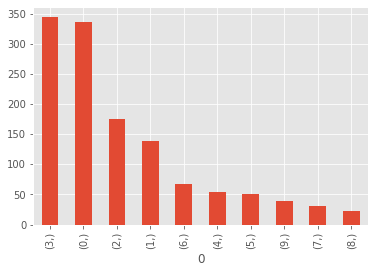

In [9]:
pd.DataFrame(y_train).value_counts().plot.bar(); #imbalanced dataset

### Train - We work only with train data

In [10]:
#Step 1: Train and test seperately
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=123, stratify=y_train)
X_train_graph, X_val_graph, y_train_graph, y_val_graph = train_test_split(
    X_train_graph, y_train, test_size=0.2, random_state=123, stratify=y_train)

In [11]:
#Step 2: Scaling the Data, for graph and text seperately

scaler = StandardScaler()
X_train_text = scaler.fit_transform(X_train_text)
X_train_graph = scaler.fit_transform(X_train_graph)
X_val_text = scaler.transform(X_val_text)
X_val_graph = scaler.transform(X_val_graph)

In [12]:
#Step 3: Combine text and graph data
X_train = np.hstack((X_train_text, X_train_graph))
X_val = np.hstack((X_val_text, X_val_graph))

y_train = y_train_graph #they are the same
y_val = y_val_graph

In [13]:
#Step 4: Data Augmentation to make up for under-represented classes
over = SMOTE(random_state=123)
X_train_new, y_train_new = over.fit_resample(X_train, y_train)
print(X_train_new.shape, y_train_new.shape)

(2750, 64) (2750,)


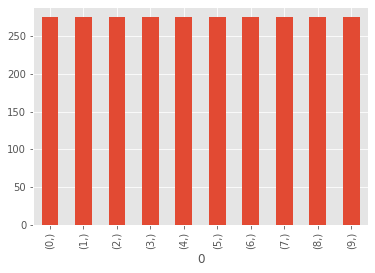

In [14]:
pd.DataFrame(y_train_new).value_counts().plot.bar(); #balanced dataset

In [15]:
#Create tensor datasets
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len__(self):
        return len(self.x)

In [46]:
#Hyperparameters
batch_size = 32
hidden_dim = 128
dropout = 0.5
n_classes = 10
n_epochs = 200
input_dim = X_train_new.shape[1]

In [47]:
train_dataset = CustomDataset(torch.Tensor(X_train_new).float(), torch.Tensor(y_train_new).float())
val_dataset = CustomDataset(torch.Tensor(X_val).float(), torch.Tensor(y_val).float())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset)

In [85]:
class kmodel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.ReLU(),
            #nn.Dropout(0.5),
            #nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            #nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_dim, out_features=n_classes),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        z = self.net(x)
        return z

In [49]:
def _train_step(model, optimizer, loss_fn):
    
    def step(X, y):
        model.train()
        pred = model(X)
        loss = loss_fn(pred, y.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    
    return step      

In [50]:
from sklearn.utils import class_weight
class_weights=class_weight.compute_class_weight('balanced',np.unique(y_train_new),y_train_new)
class_weights=torch.tensor(class_weights,dtype=torch.float)

/opt/venv/causal/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[0 3 2 ... 9 9 9] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [51]:
model = kmodel(input_dim=input_dim, hidden_dim=hidden_dim, dropout=dropout, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(params=model.parameters(), lr=0.00001)

In [52]:
model = model.to(device)
train_step = _train_step(model, optimizer, loss_fn)

train_loss = []
eval_loss = []
best_val_loss = 100

for epoch in range(n_epochs):
    t_loss = []
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        loss = train_step(x, y)
        t_loss.append(loss)
    train_loss.append(np.mean(t_loss))   

    with torch.no_grad():
        preds = model(val_dataset.x.to(device))
        loss = loss_fn(preds, val_dataset.y.long().to(device))
        eval_loss.append(loss.cpu())

    # Remember best validation loss and save checkpoint
    is_best = loss <= best_val_loss
    best_val_loss = min(loss, best_val_loss)
    if is_best:
        torch.save({
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, 'model_best.pth.tar')
        
    if epoch%20 == 0:
        print(f'Epoch: {epoch}, Train Loss: {train_loss[-1]}, Validation Loss: {eval_loss[-1]}')

Epoch: 0, Train Loss: 2.3116547895032307, Validation Loss: 2.379054546356201
Epoch: 20, Train Loss: 2.0398237095322718, Validation Loss: 1.9396226406097412
Epoch: 40, Train Loss: 1.7882567907488622, Validation Loss: 1.6581121683120728
Epoch: 60, Train Loss: 1.5754705681357273, Validation Loss: 1.5682622194290161
Epoch: 80, Train Loss: 1.3774607846903246, Validation Loss: 1.4061583280563354
Epoch: 100, Train Loss: 1.2317502699619116, Validation Loss: 1.4391913414001465
Epoch: 120, Train Loss: 1.0918588596721028, Validation Loss: 1.3478244543075562
Epoch: 140, Train Loss: 0.9774547683638196, Validation Loss: 1.3862003087997437
Epoch: 160, Train Loss: 0.9074463269045187, Validation Loss: 1.4214435815811157
Epoch: 180, Train Loss: 0.8422430088353712, Validation Loss: 1.371079921722412


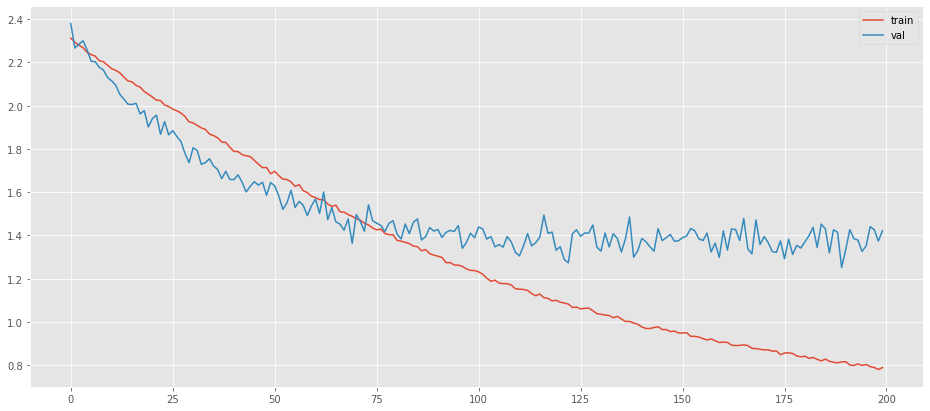

In [55]:
fig, ax =plt.subplots(figsize=(16, 7))
ax.plot(train_loss, label='train')
ax.plot(eval_loss, label='val')
plt.legend();

In [53]:
# Make predictions
checkpoint = torch.load('model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()
y_pred = list()
for x in val_loader:
    x = x[0].to(device)
    output = model(x)
    y_pred.append(torch.exp(output))
y_pred = torch.cat(y_pred, dim=0).detach().cpu().numpy()
accuracy_score(y_pred.argmax(axis=1), y_val)

0.6388888888888888

In [73]:
print(classification_report(y_pred.argmax(axis=1), y_val))

              precision    recall  f1-score   support

           0       0.93      0.55      0.69       112
           1       0.75      0.95      0.84        22
           2       0.37      0.59      0.46        22
           3       0.64      0.92      0.75        48
           4       0.64      0.44      0.52        16
           5       0.50      0.62      0.56         8
           6       0.21      0.25      0.23        12
           7       0.33      0.67      0.44         3
           8       0.00      0.00      0.00         1
           9       0.50      0.50      0.50         8

    accuracy                           0.64       252
   macro avg       0.49      0.55      0.50       252
weighted avg       0.72      0.64      0.65       252



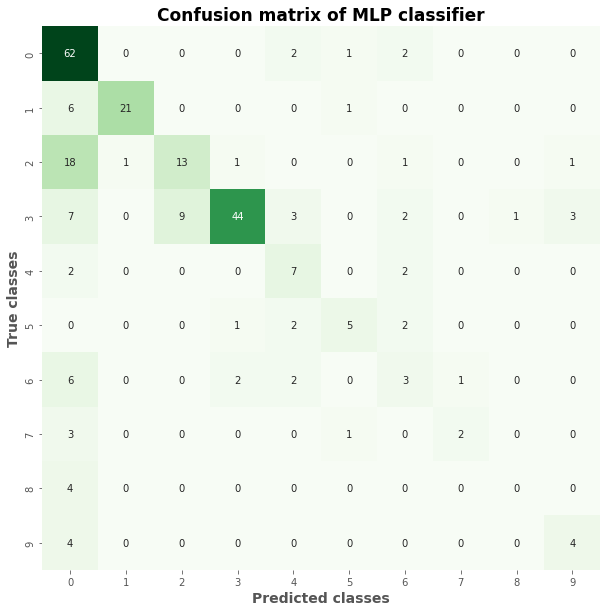

In [76]:
conf_matr(np.array(list(map(int, y_val_text))), np.argmax(y_pred, axis=1),4)

In [56]:
#BASELINE LR
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score 

weights = {k:v for k,v in zip(range(10), class_weights.numpy())}
clf = LogisticRegressionCV(max_iter=10000, n_jobs=-1, random_state=123, class_weight=weights)
clf.fit(X_train_new, y_train_new)
print(accuracy_score(clf.predict(X_val), y_val))

0.6309523809523809


### Hypertuning 

In [58]:
import optuna

In [59]:
def define_model(trial):
    # We optimize the number of layers, hidden untis and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = input_dim
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_uniform("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, n_classes))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)

In [60]:
def objective(trial):

    # Generate the model.
    model = define_model(trial).to(device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    train_step = _train_step(model, optimizer, loss_fn)

    train_loss = []
    eval_loss = []
    best_val_loss = 100

    for epoch in range(n_epochs):
        t_loss = []
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
        
            loss = train_step(x, y)
            t_loss.append(loss)
        train_loss.append(np.mean(t_loss))   

        with torch.no_grad():
            preds = model(val_dataset.x.to(device))
            loss = loss_fn(preds, val_dataset.y.long().to(device))
            eval_loss.append(loss.cpu())
    prd = model(torch.Tensor(X_val).to(device)).argmax(axis=1).cpu().numpy()
    accuracy = accuracy_score(prd, y_val)
    
    return accuracy


In [63]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=40)

    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-06-12 19:50:32,478] A new study created in memory with name: no-name-1b584694-0ce2-404a-aac7-800d1218b0f9
[I 2022-06-12 19:50:48,853] Trial 0 finished with value: 0.2896825396825397 and parameters: {'n_layers': 2, 'n_units_l0': 15, 'dropout_l0': 0.4667786700834963, 'n_units_l1': 86, 'dropout_l1': 0.4133662896040269, 'optimizer': 'RMSprop', 'lr': 1.2610398559590214e-05}. Best is trial 0 with value: 0.2896825396825397.
[I 2022-06-12 19:51:03,556] Trial 1 finished with value: 0.6190476190476191 and parameters: {'n_layers': 1, 'n_units_l0': 101, 'dropout_l0': 0.4394240361420798, 'optimizer': 'Adam', 'lr': 0.0030484253833114147}. Best is trial 1 with value: 0.6190476190476191.
[I 2022-06-12 19:51:16,864] Trial 2 finished with value: 0.5912698412698413 and parameters: {'n_layers': 1, 'n_units_l0': 113, 'dropout_l0': 0.3379057969036778, 'optimizer': 'RMSprop', 'lr': 0.07532101542817812}. Best is trial 1 with value: 0.6190476190476191.
[I 2022-06-12 19:51:31,144] Trial 3 finished with 

[I 2022-06-12 19:57:51,908] Trial 27 finished with value: 0.6190476190476191 and parameters: {'n_layers': 1, 'n_units_l0': 100, 'dropout_l0': 0.4986680894350941, 'optimizer': 'Adam', 'lr': 3.386632851787891e-05}. Best is trial 16 with value: 0.6865079365079365.
[I 2022-06-12 19:58:06,113] Trial 28 finished with value: 0.5992063492063492 and parameters: {'n_layers': 1, 'n_units_l0': 63, 'dropout_l0': 0.31519082524248543, 'optimizer': 'Adam', 'lr': 1.0797176320330598e-05}. Best is trial 16 with value: 0.6865079365079365.
[I 2022-06-12 19:58:20,467] Trial 29 finished with value: 0.14682539682539683 and parameters: {'n_layers': 2, 'n_units_l0': 78, 'dropout_l0': 0.25003904480649636, 'n_units_l1': 56, 'dropout_l1': 0.48780455822737545, 'optimizer': 'SGD', 'lr': 2.102669690949191e-05}. Best is trial 16 with value: 0.6865079365079365.
[I 2022-06-12 19:58:37,416] Trial 30 finished with value: 0.5912698412698413 and parameters: {'n_layers': 2, 'n_units_l0': 52, 'dropout_l0': 0.2925272681070155,

Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  0
  Number of complete trials:  40
Best trial:
  Value:  0.6865079365079365
  Params: 
    n_layers: 1
    n_units_l0: 82
    dropout_l0: 0.3620320439761883
    optimizer: Adam
    lr: 7.775391632812434e-05


### Final Predictions

In [77]:
# Read training data
train_domains = list()
y_train = list()
with open("train.txt", "r") as f:
    for line in f:
        l = line.split(",")
        train_domains.append(l[0])
        y_train.append(l[1][:-1])
y_train = np.array(list(map(int, y_train)))

#LOAD DATA
with open('X_train_text_d2v', 'rb') as handle:
    X_train_text = pickle.load(handle)
with open('X_train_graph_n2v', 'rb') as handle:
    X_train_graph = pickle.load(handle)
    
    
with open('X_test_text_d2v', 'rb') as handle:
    X_test_text = pickle.load(handle)
with open('X_test_graph_n2v', 'rb') as handle:
    X_test_graph = pickle.load(handle)

In [78]:
#Standardization
scaler = StandardScaler()
X_train_text = scaler.fit_transform(X_train_text)
X_train_graph = scaler.fit_transform(X_train_graph)
X_test_text = scaler.transform(X_test_text)
X_test_graph = scaler.transform(X_test_graph)

#Combine data
X_train = np.hstack((X_train_text, X_train_graph))
X_test = np.hstack((X_test_text, X_test_graph))

In [79]:
#data augmetnation
over = SMOTE(random_state=123)
X_train_new, y_train_new = over.fit_resample(X_train, y_train)
print(X_train_new.shape, y_train_new.shape)

(3440, 64) (3440,)


In [80]:
train_dataset = CustomDataset(torch.Tensor(X_train_new).float(), torch.Tensor(y_train_new).float())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

tensor_x = torch.FloatTensor(X_test)
test_dataset = utils.TensorDataset(tensor_x)
test_loader = utils.DataLoader(test_dataset, batch_size=batch_size)

In [83]:
#New hyperparameters
hidden_dim = 82
dropout = 0.3620320439761883
lr = 7.775391632812434e-05
n_epochs = 80
study.best_params

{'n_layers': 1,
 'n_units_l0': 82,
 'dropout_l0': 0.3620320439761883,
 'optimizer': 'Adam',
 'lr': 7.775391632812434e-05}

In [86]:
model = kmodel(input_dim=input_dim, hidden_dim=hidden_dim, dropout = dropout, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [87]:
#device='cpu'
model = model.to(device)
train_step = _train_step(model, optimizer, loss_fn)
#eval_step = _eval_step(model, loss_fn)
train_loss = []
eval_loss = []
for epoch in range(n_epochs):
    t_loss = []
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        loss = train_step(x, y)
        t_loss.append(loss)
    train_loss.append(np.mean(t_loss))   
    
    if epoch%20 == 0:
        print(f'Epoch: {epoch}, Train Loss: {train_loss[-1]}')

Epoch: 0, Train Loss: 2.301460564136505
Epoch: 20, Train Loss: 0.9186293223389873
Epoch: 40, Train Loss: 0.6357779099985406
Epoch: 60, Train Loss: 0.5429420333217692


In [89]:
# Make predictions
model.eval()
y_pred = list()
for x in test_loader:
    x = x[0].to(device)
    output = model(x)
    y_pred.append(torch.exp(output))
y_pred = torch.cat(y_pred, dim=0).detach().cpu().numpy()

In [90]:
y_pred.argmax(1), y_pred.shape

(array([6, 0, 1, 0, 6, 2, 0, 0, 3, 1, 1, 3, 0, 0, 2, 0, 2, 0, 4, 0, 4, 0,
        9, 0, 4, 0, 1, 1, 6, 0, 1, 0, 0, 0, 3, 6, 3, 3, 0, 2, 0, 6, 0, 0,
        5, 0, 2, 1, 0, 0, 3, 0, 1, 5, 0, 3, 3, 1, 0, 2, 1, 0, 4, 2, 0, 9,
        2, 9, 0, 4, 3, 0, 1, 4, 3, 1, 4, 2, 3, 7, 2, 0, 2, 4, 9, 0, 0, 0,
        6, 0, 5, 0, 0, 5, 0, 0, 4, 4, 0, 3, 2, 3, 4, 3, 3, 2, 3, 5, 5, 5,
        7, 4, 2, 3, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 1, 3, 9, 2, 0, 2, 0,
        0, 2, 2, 3, 2, 1, 1, 1, 0, 6, 6, 0, 4, 2, 3, 3, 1, 1, 1, 1, 0, 3,
        3, 5, 0, 0, 3, 4, 2, 0, 6, 3, 3, 3, 0, 2, 1, 3, 0, 2, 3, 0, 0, 5,
        0, 0, 0, 3, 0, 3, 0, 9, 7, 0, 3, 0, 0, 5, 3, 6, 2, 1, 2, 0, 4, 0,
        2, 2, 6, 6, 4, 0, 3, 0, 3, 2, 0, 0, 0, 2, 0, 2, 2, 4, 3, 0, 3, 0,
        3, 0, 3, 0, 2, 0, 0, 3, 0, 1, 6, 0, 0, 0, 2, 0, 0, 7, 0, 2, 3, 0,
        1, 1, 0, 0, 3, 3, 2, 0, 0, 0, 2, 0, 6, 0, 4, 2, 2, 3, 0, 0, 2, 3,
        6, 3, 1, 5, 3, 2, 2, 5, 2, 0, 1, 0, 0, 1, 1, 5, 1, 3, 0, 0, 6, 6,
        1, 3, 2, 0, 2, 0, 4, 0, 6, 0, 

In [91]:
# Write predictions to a file
with open('sample_submission.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(10):
        lst.append('class_'+str(i))
    lst.insert(0, "domain_name")
    writer.writerow(lst)
    for i,test_host in enumerate(test_domains):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)